created by Ignacio Oguiza - email: oguiza@gmail.com

# How to efficiently work with very large Numpy Arrays?

## Import libraries

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

## Introduction

I normally work with time series data. I made the decision to use numpy arrays to store my data since the can easily handle multiple dimensions, and are really very efficient.

But sometimes datasets are really big (many GBs) and don't fit in memory. So I started looking around and found something that works very well: [**np.memmap**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.memmap.html). Conceptually they work as arrays on disk, and that's how I often call them.

np.memmap creates a map to numpy array you have previously saved on disk, so that you can efficiently access small segments of those (small or large) files on disk, without reading the entire file into memory. And that's exactly what we need with deep learning, be able to quickly create a batch in memory, without reading the entire file (that is stored on disk). 

The best analogy I've found are image files. You may have a very large dataset on disk (that far exceeds your RAM). In order to create your DL datasets, what you pass are the paths to each individual file, so that you can then load a few images and create a batch on demand.

You can view np.memmap as the path collection that can be used to load numpy data on demand when you need to create a batch.

So let's see how you can work with larger than RAM arrays on disk.

On my laptop I have only 8GB of RAM.

In [620]:
from fastai2.data.all import *
from fastai2.torch_core import *
from timeseries.core import *
from timeseries.imports import *
from timeseries.utils import *
print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

Total RAM      :  8.00 GB
Available RAM  :  2.35 GB



In [396]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

I will try to demonstrate how you can handle a 10 GB numpy array dataset in an efficient way. 

## Create and save a larger than memory array

I will now create a large numpy array that doesn't fit in memory. 
Since I don't have enough RAM, I'll create an empty array on disk, and then load data in chunks that fit in memory.

⚠️ If you want to to experiment with large datasets, you may uncomment and run this code. **It will create a ~10GB on your disk**. 
If you do it, remember to delete it later.
In my laptop it took me around **11 mins to run.**

In [3]:
# # Save a small empty array
# X_temp_fn = './data/temp_X.npy'
# np.save(X_temp_fn, np.empty(1))

# # Create a np.memmap with desired dtypes and shape of the large array you want to save.
# # It's just a placeholder that doesn't contain any data
# X_fn = './data/X_on_disk.npy'
# X = np.memmap(X_temp_fn, dtype='float32', shape=(100000, 50, 512))

# # We are going to create a loop to fill in the np.memmap
# start = 0
# for i in range(20):
#     # You now grab a chunk of your data that fits in memory
#     # This could come from a pandas dataframe for example
#     # I will simulate it with some random data
#     data_chunk = np.random.rand(5000, 50, 512)
#     end = start + data_chunk.shape[0]
    
#     # I now fill a slice of the np.memmap
#     X[start:end] = data_chunk
    
#     start = end
#     del data_chunk

# #I can now remove the temp file I created
# os.remove(X_temp_fn)

# # Once the data is loaded on the np.memmap, I save it as a normal np.array
# np.save(X_fn, X)

# # I will create a smaller array. Sinc this fits in memory, I don't need to use a memmap
# y_fn = 'y_on_disk.npy'
# y = np.random.randint(0, 10, X.shape[0])
# labels = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
# np.save(y_fn, labels[y])

# del X, y

Ok. So let's check the size of these files on memory.

In [4]:
print(f'X array: {os.path.getsize("./data/X_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("./data/X_on_disk.npy")):3.3f} GB)')
print(f'y array: {os.path.getsize("./data/y_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("./data/y_on_disk.npy")):3.3f} GB)')

X array:  10240000128 bytes (9.540 GB)
y array:       400128 bytes (0.000 GB)


## Load an array on disk (np.memmap)

Remember I only have an 8 GB RAM on this laptop, so I couldn't load these datasets in memory.

☣️ Actually I accidentally loaded the "X_on_disk.npy" file, and my laptop crahsed so I had to reboot it!

So let's now load data as arrays on disk (np.memmap). The way to do it is super simple, and very efficient. You just do it as you would with a normal array, but add an mmap_mode.

There are 4 modes: 

- ‘r’	Open existing file for reading only.
- ‘r+’	Open existing file for reading and writing.
- ‘w+’	Create or overwrite existing file for reading and writing.
- ‘c’	Copy-on-write: assignments affect data in memory, but changes are not saved to disk. The file on disk is read-only.

I normally use mode 'r' since I want to be able to make changes to data in memory (transforms for example), without affecting data on disk (same approach as with image data). This is the same thing you do with image files on disk, that are just read, and then modified in memory, without change the file on disk.

In [92]:
X_in_memory = np.load('./data/X_on_disk_small.npy')
# y_in_memory = np.load('./data/y_on_disk_small.npy')
y_in_memory = np.random.randint(0, 10, len(X_in_memory))
X_in_memory_items = itemify(X_in_memory)
Xy_in_memory_items = itemify(X_in_memory, y_in_memory)
X_in_memory.shape

(10000, 50, 512)

In [460]:
X_in_memory = np.random.rand(8236, 1, 1024).astype('float32')
y_in_memory = np.random.randint(0, 10, len(X_in_memory))
X_in_memory_items = itemify(X_in_memory)
Xy_in_memory_items = itemify(X_in_memory, y_in_memory)
X_in_memory.shape, X_in_memory.dtype

((8236, 1, 1024), dtype('float32'))

In [91]:
X_on_disk = np.load('./data/X_on_disk_small.npy', mmap_mode='r')
# y_on_disk = np.load('./data/y_on_disk_small.npy', mmap_mode='r')
y_on_disk = np.random.randint(0, 10, len(X_on_disk))
X_on_disk_items = itemify(X_on_disk)
Xy_on_disk_items = itemify(X_on_disk, y_on_disk)
X_on_disk.shape

(10000, 50, 512)

In [461]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
index = np.random.permutation(np.arange(len(X_in_memory)))
splits = L([index[:7000], index[7000:]])
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

In [187]:
def create_batch_from_items(items, idx):
    return ([torch.from_numpy(np.stack(tl)) if i == 0 else np.stack(tl) 
                  for i,tl in enumerate(zip(*items[idx]))])

xb, yb = create_batch_from_items(Xy_in_memory_items, idx=idx)
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), (128,))

In [196]:
def create_batch_from_items2(items, idx):
    res = items[idx]
    return ([torch.from_numpy(np.stack(tl)) if i == 0 else np.stack(tl) 
                  for i,tl in enumerate(list(zip(*res)))])

xb, yb = create_batch_from_items2(Xy_in_memory_items, idx=idx)
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), (128,))

In [188]:
def create_batch_from_arrays(os, idx=None):
    return ([torch.as_tensor(o[idx]) if i == 0 else o[idx] for i,o in enumerate(os)])

xb, yb = create_batch_from_arrays((X_in_memory, y_in_memory), idx=idx)
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), (128,))

In [189]:
%timeit create_batch_from_items(Xy_in_memory_items, idx)

1.93 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [197]:
%timeit create_batch_from_items2(Xy_in_memory_items, idx)

1.82 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [190]:
%timeit create_batch_from_arrays((X_in_memory, y_in_memory), idx=idx)

269 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [171]:
%timeit create_batch_from_items(Xy_on_disk_items, idx)

17.8 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [173]:
%timeit create_batch_from_arrays((X_on_disk, y_on_disk), idx=idx)

13.5 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
%timeit (torch.from_numpy(X_in_memory[idx]), torch.from_numpy(y_in_memory[idx]))

23.7 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
%timeit (torch.from_numpy(X_on_disk[idx]), torch.from_numpy(y_on_disk[idx]))

26.3 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [537]:
class NumpyDatasets2():
    def __init__(self, X, y=None, sel_vars=None, sel_steps=None, splits=None, split=None, split_idx=None, **kwargs):
        self.X,self.y,self.splits,self.split = X,y,splits,split
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps
        
    def __getitem__(self, idx):
        if self.split is not None: idx = self.split[idx] 
        if self.y is None: return (self.X[idx, self.sel_vars, self.sel_steps], )
        else:  return (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx])

    def __len__(self):
        return len(self.X) if self.split is None else len(self.split)
    
    def subset(self, i): 
        if self.splits is None: self.splits = [np.arange(len(self.X))]
        return type(self)(X=self.X, y=self.y, sel_vars=self.sel_vars, 
                          sel_steps=self.sel_steps, split=self.splits[i], split_idx=i)
    
    def __repr__(self): return coll_repr(self)
    
    @property
    def train(self): return self.subset(0)
    
    @property
    def valid(self): return self.subset(1)
    
    
class TSDatasets2(NumpyDatasets2):
    def __getitem__(self, idx):
        if self.split is not None: idx = self.split[idx] 
        if self.y is None: return (torch.as_tensor(self.X[idx, self.sel_vars, self.sel_steps]), )
        else:  return (torch.as_tensor(self.X[idx, self.sel_vars, self.sel_steps]), self.y[idx])
        
    
class TSDataLoader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, num_workers=0, **kwargs):
        super().__init__(dataset, num_workers=num_workers, **kwargs)
    def create_batch(self, b): return self.dataset[b]

In [538]:
dsets = TSDatasets2(X_in_memory, y_in_memory)
train_ds = dsets.train
xb, yb = train_ds[train_idx]
len(train_ds), xb.shape, yb.shape

(8236, torch.Size([128, 1, 1024]), (128,))

In [528]:
len(list(chunked(np.arange(len(train_ds)), 128)))

65

In [533]:
chunks = chunked(np.arange(len(ds)), 128)

def cycle_ds(ds, chunks=None):
    if chunks is None: chunks = chunked(np.arange(len(ds)), 128)
    for idx in chunks:
        _ = ds[idx]
        
cycle_ds(train_ds, chunks)

In [534]:
%timeit cycle_ds(train_ds, chunks)

470 ns ± 4.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [516]:
%timeit train_ds[train_idx]

173 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [512]:
train_dl = torch.utils.data.DataLoader(dataset=dsets.train, batch_size=128)
xb,yb = next(iter(train_dl))
xb, yb

(tensor([[[0.7893, 0.4066, 0.8080,  ..., 0.8776, 0.5709, 0.0694]],
 
         [[0.5133, 0.8600, 0.1148,  ..., 0.3096, 0.3210, 0.0861]],
 
         [[0.2545, 0.5694, 0.1404,  ..., 0.8457, 0.4543, 0.6036]],
 
         ...,
 
         [[0.7951, 0.9280, 0.0888,  ..., 0.4516, 0.9465, 0.3413]],
 
         [[0.2978, 0.1751, 0.2217,  ..., 0.0978, 0.3504, 0.3807]],
 
         [[0.7931, 0.8853, 0.3646,  ..., 0.7148, 0.1426, 0.8407]]]),
 tensor([2, 4, 3, 8, 8, 1, 6, 2, 2, 3, 0, 1, 2, 0, 7, 6, 1, 5, 9, 6, 3, 2, 1, 3,
         7, 5, 6, 9, 9, 7, 4, 4, 3, 9, 3, 3, 2, 5, 3, 5, 5, 8, 4, 5, 7, 8, 1, 2,
         2, 0, 1, 1, 7, 9, 8, 0, 3, 1, 0, 9, 5, 6, 4, 0, 3, 9, 7, 1, 1, 2, 8, 4,
         2, 6, 7, 3, 9, 9, 1, 8, 5, 0, 8, 1, 6, 6, 0, 6, 2, 7, 8, 7, 4, 1, 2, 3,
         2, 2, 0, 0, 3, 4, 8, 1, 7, 0, 6, 0, 5, 4, 5, 9, 1, 0, 1, 9, 7, 2, 3, 1,
         4, 8, 0, 6, 6, 5, 3, 6]))

In [497]:
%timeit cycle_dl(train_dl)

247 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [517]:
train_dl = TSDataLoader(dsets.train, bs=128, shuffle=False)
xb, yb = next(iter(train_dl))
xb, yb

(tensor([[[0.7893, 0.4066, 0.8080,  ..., 0.8776, 0.5709, 0.0694]],
 
         [[0.5133, 0.8600, 0.1148,  ..., 0.3096, 0.3210, 0.0861]],
 
         [[0.2545, 0.5694, 0.1404,  ..., 0.8457, 0.4543, 0.6036]],
 
         ...,
 
         [[0.7951, 0.9280, 0.0888,  ..., 0.4516, 0.9465, 0.3413]],
 
         [[0.2978, 0.1751, 0.2217,  ..., 0.0978, 0.3504, 0.3807]],
 
         [[0.7931, 0.8853, 0.3646,  ..., 0.7148, 0.1426, 0.8407]]]),
 array([2, 4, 3, 8, 8, 1, 6, 2, 2, 3, 0, 1, 2, 0, 7, 6, 1, 5, 9, 6, 3, 2,
        1, 3, 7, 5, 6, 9, 9, 7, 4, 4, 3, 9, 3, 3, 2, 5, 3, 5, 5, 8, 4, 5,
        7, 8, 1, 2, 2, 0, 1, 1, 7, 9, 8, 0, 3, 1, 0, 9, 5, 6, 4, 0, 3, 9,
        7, 1, 1, 2, 8, 4, 2, 6, 7, 3, 9, 9, 1, 8, 5, 0, 8, 1, 6, 6, 0, 6,
        2, 7, 8, 7, 4, 1, 2, 3, 2, 2, 0, 0, 3, 4, 8, 1, 7, 0, 6, 0, 5, 4,
        5, 9, 1, 0, 1, 9, 7, 2, 3, 1, 4, 8, 0, 6, 6, 5, 3, 6]))

In [518]:
%timeit cycle_dl(train_dl)

72.5 ms ± 798 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [347]:
train_ds[0, 1]

(tensor([[[0.9056, 0.2924, 0.7631,  ..., 0.5925, 0.3613, 0.3369]],
 
         [[0.2004, 0.7806, 0.2996,  ..., 0.3589, 0.7574, 0.3505]]]),
 array([0, 0]))

In [351]:
%timeit train_ds[train_idx]

250 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [550]:
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, preprocess=False, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        
        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        
        if preprocess: self.ptls = itemify([tl[:] for tl in self.tls])
        else: self.ptls = self.tls
        self.preprocess = preprocess

    def __getitem__(self, it):
        if self.preprocess: res = self.ptls[it]
        else: res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, preprocess=self.preprocess)
    def _new(self, *args, X=None, y=None, items=None, **kwargs): return super()._new(X=X, y=y, items=items, tfms=self.tfms, 
                                                                                     do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

In [551]:
dsets = NumpyDatasets(X_in_memory, y_in_memory)
train_ds = dsets.train
o = train_ds[train_idx]

In [568]:
tuple(TfmdLists(y_in_memory, Categorize())[:])

TensorCategory(2)

In [698]:
Normalize??

In [697]:
idx 

(TSTensor(samples:128, vars:50, len:512),
 tensor([[0.8820, 0.6734, 0.8180,  ..., 0.5689, 0.2792, 0.3668],
         [0.8213, 0.7132, 0.9676,  ..., 0.9788, 0.7889, 0.8886],
         [0.2028, 0.8744, 0.6563,  ..., 0.7629, 0.6458, 0.9421],
         ...,
         [0.0130, 0.0788, 0.3215,  ..., 0.8222, 0.0345, 0.8217],
         [0.1284, 0.9962, 0.1713,  ..., 0.7226, 0.0071, 0.8336],
         [0.3945, 0.9712, 0.1988,  ..., 0.5232, 0.1200, 0.4968]]),
 tensor([[0.8820, 0.6734, 0.8180,  ..., 0.5689, 0.2792, 0.3668],
         [0.8213, 0.7132, 0.9676,  ..., 0.9788, 0.7889, 0.8886],
         [0.2028, 0.8744, 0.6563,  ..., 0.7629, 0.6458, 0.9421],
         ...,
         [0.0130, 0.0788, 0.3215,  ..., 0.8222, 0.0345, 0.8217],
         [0.1284, 0.9962, 0.1713,  ..., 0.7226, 0.0071, 0.8336],
         [0.3945, 0.9712, 0.1988,  ..., 0.5232, 0.1200, 0.4968]]))

In [642]:
TSTensor(X_in_memory[[0,1]])

TSTensor(samples:2, vars:1, len:1024)

In [668]:
y = y_in_memory
tfms = [add(100), Categorize()]
tl = TfmdLists(y, tfms)
ptl = tl[:]
ptl = retain_type(np.stack(ptl), typ=type(ptl[0]))
res = ptl[:128]
type(res), res[:128], tl.decode(res[:128])

IndexError: too many indices for tensor of dimension 1

In [670]:
type(res), res[:128], tl.decode(res[:128])

(fastai2.torch_core.TensorCategory,
 tensor([2, 4, 3, 8, 8, 1, 6, 2, 2, 3, 0, 1, 2, 0, 7, 6, 1, 5, 9, 6, 3, 2, 1, 3,
         7, 5, 6, 9, 9, 7, 4, 4, 3, 9, 3, 3, 2, 5, 3, 5, 5, 8, 4, 5, 7, 8, 1, 2,
         2, 0, 1, 1, 7, 9, 8, 0, 3, 1, 0, 9, 5, 6, 4, 0, 3, 9, 7, 1, 1, 2, 8, 4,
         2, 6, 7, 3, 9, 9, 1, 8, 5, 0, 8, 1, 6, 6, 0, 6, 2, 7, 8, 7, 4, 1, 2, 3,
         2, 2, 0, 0, 3, 4, 8, 1, 7, 0, 6, 0, 5, 4, 5, 9, 1, 0, 1, 9, 7, 2, 3, 1,
         4, 8, 0, 6, 6, 5, 3, 6]),
 '(#128) [102,104,103,108,108,101,106,102,102,103...]')

In [666]:
ptl[0], tl[0]

(TensorCategory(2), TensorCategory(2))

In [587]:
class TensorCategory(TensorBase):
    def __get_item__(o, idx): retain_type(o[idx])


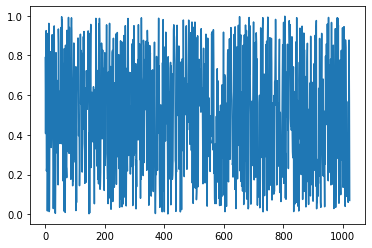

In [580]:
plt.plot(X_in_memory[0].T);

In [407]:
class TSDataloader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms) + ReadTSBatch(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset[b]
    
train_dl = TSDataLoader(train_ds)
xb, yb = next(iter(train_dl))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nacho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-407-d3e06c743344>", line 10, in <module>
    xb, yb = next(iter(train_dl))
  File "/Users/nacho/anaconda3/lib/python3.7/site-packages/fastai2/data/load.py", line 97, in __iter__
    for b in _loaders[self.fake_l.num_workers==0](self.fake_l):
  File "/Users/nacho/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 684, in __init__
    self._worker_result_queue = multiprocessing_context.Queue()
  File "/Users/nacho/anaconda3/lib/python3.7/multiprocessing/context.py", line 102, in Queue
    return Queue(maxsize, ctx=self.get_context())
  File "/Users/nacho/anaconda3/lib/python3.7/multiprocessing/queues.py", line 41, in __init__
    self._reader, self._writer = connection.Pipe(duplex=False)
  File "/Users/nacho/anaconda3/lib/python3.7/multip

OSError: [Errno 24] Too many open files

In [479]:
class Slicer:
    "slice numpy ds"
    def __init__(self,to): self.to = to
    def __getitem__(self, idxs):
        return self.to.new(*self.to[idxs])

class NumpyDataset2():
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (self.X[idx], self.y[idx])

    def __len__(self):
        return len(self.X)

    @property
    def slicer(self):
        return Slicer(self)

    def new(self, X, y):
        return type(self)(X, y)

class ReadTSBatch(ItemTransform):
    def __init__(self, to): self.to = to

    def encodes(self, to):
        res = (tensor(to.X).float(), )
        res = res + (tensor(to.y),)
        # if to.device is not None: res = to_device(res, to.device)
        return res
    
class TSDataloader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTSBatch(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.slicer[b]

In [480]:
ds = NumpyDataset2(X_in_memory, y_in_memory)
rtb = ReadTSBatch(ds) 
xb, yb = rtb.encodes(ds)#.slicer[[0,3,5]]
xb.shape, yb.shape

(torch.Size([8236, 1, 1024]), torch.Size([8236]))

In [481]:
class TSDataloader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms) + ReadTSBatch(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.slicer[b]
    
dl = TSDataloader(ds, bs=128, shuffle=True)
xb, yb = next(iter(dl))
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), torch.Size([128]))

In [482]:
dl = TSDataloader(ds, bs=128, shuffle=True)
xb, yb = next(iter(dl))
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), torch.Size([128]))

In [369]:
def cycle_dl(dl):
    for _ in iter(dl): pass

In [483]:
%timeit cycle_dl(dl)

82.7 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit create_batch_from_items(Xy_in_memory_items, idx_in_memory)

27.8 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit (X_in_memory[idx_in_memory], y_in_memory[idx_in_memory])

26.3 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit list(zip(*Xy_in_memory_items[idx_in_memory]))

191 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit (X_in_memory[idx_in_memory], y_in_memory[idx_in_memory])

474 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit Xy_in_memory_items[idx_in_memory]

154 µs ± 3.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
%timeit X_in_memory[0]

660 ns ± 3.93 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [28]:
%timeit X_in_memory[idx_in_memory]

209 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
%timeit X_in_memory_items[idx_in_memory]

155 µs ± 840 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit Xy_on_disk_items[idx_ond_disk]

In [33]:
%timeit Xy_on_disk_items[idx_ond_disk]

158 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
X_zip = itemify(X_on_disk)

In [13]:
%timeit X_zip[idx]

156 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit X_on_disk[idx]

6.99 ms ± 9.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit X_on_disk[:128]

11 µs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%timeit X_on_disk[0]

10.9 µs ± 224 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
10.9*128

1395.2

**Fast load**: it only takes a few ms to "load" a memory map to a 10 GB array on disk.

In fact, the only thing that is loaded is a map to the array stored on disk. That's why it's so fast.

## Arrays on disk: main features

### Very limited RAM usage

In [39]:
print(X_on_disk.shape, y_on_disk.shape)

(100000, 50, 512) (100000,)


In [6]:
print(f'X array on disk: {sys.getsizeof(X_on_disk):12} bytes ({bytes2GB(sys.getsizeof(X_on_disk)):3.3f} GB)')
print(f'y array on disk: {sys.getsizeof(y_on_disk):12} bytes ({bytes2GB(sys.getsizeof(y_on_disk)):3.3f} GB)')

X array on disk:          152 bytes (0.000 GB)
y array on disk:          120 bytes (0.000 GB)


**152 bytes of RAM for a 10GB array**. This is the great benefit of arrays on disk.

Arrays on disk barely use any RAM until each the it's sliced and an element is converted into a np.array or a tensor.

This is equivalent to the size of file paths in images (very limited) compared to the files themselves (actual images). 

### Types

np.memmap is a subclass of np.ndarray

In [7]:
isinstance(X_on_disk, np.ndarray)

True

In [8]:
type(X_on_disk)

numpy.memmap

### Operations

With np.memmap you can perform the same operations you would with a normal numpy array. 
The most common operations you will perform in deep learning are:

- slicing
- calculating stats: mean and std
- scaling (using normalize or standardize)
- transformation into a tensor

Once you get the array on disk slice, you'll convert it into a tensor, move to a GPU and performs operations there.


⚠️ You need to be careful though not to convert the entire np.memmap to an array/ tensor if it's larger than your RAM. This will crash your computer unless you have enough RAM, so you would have to reboot!

**DON'T DO THIS:  torch.from_numpy(X) or np.array(X)** unless you have ehough RAM.

To avoid issues during test, I created a smaller array on disk (that I can store in memory). When I want to test something I test it with that array first. It's important to always verify that the type output of your operations is np.memmap, which means data is still in memory.

#### Slicing

To ensure you don't brind the entire array in memory (which may crash your computer) you can always work with slices of data, which is by the way how fastai works.

If you use mode 'r' you can grab a sample and make changes to it, but this won't modify data on disk.

In [9]:
x = X_on_disk[0]
x

memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 , 0.01147997,
         0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165, 0.20462573,
         0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 , 0.56657016,
         0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667, 0.6954193 ,
         0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647, 0.9133351 ,
         0.5418618 ]], dtype=float32)

It's important to note thatn when we perform an math operation on a np.memmap (add, subtract, ...) the output is a np.array, and no longer a np.memmap. 

⚠️ Remember you don't want to run this type of operations with a memmap larger than your RAM!! That's why I do it with a slice.

In [10]:
x = X_on_disk[0] + 1
x

array([[1.2626543, 1.8109035, 1.3246422, ..., 1.238395 , 1.6775734,
        1.3310132],
       [1.7845197, 1.6812307, 1.384214 , ..., 1.5383686, 1.01148  ,
        1.132354 ],
       [1.6679299, 1.5670733, 1.0230817, ..., 1.7735116, 1.2046257,
        1.9898304],
       ...,
       [1.3863003, 1.5770135, 1.1809583, ..., 1.9798217, 1.5665702,
        1.6018766],
       [1.0903013, 1.0174716, 1.5882474, ..., 1.2834467, 1.6954193,
        1.9359934],
       [1.9186354, 1.012525 , 1.4146458, ..., 1.8034865, 1.9133351,
        1.5418618]], dtype=float32)

In [11]:
x = torch.from_numpy(X_on_disk[0])
x2 = x + 1
x2

tensor([[1.2627, 1.8109, 1.3246,  ..., 1.2384, 1.6776, 1.3310],
        [1.7845, 1.6812, 1.3842,  ..., 1.5384, 1.0115, 1.1324],
        [1.6679, 1.5671, 1.0231,  ..., 1.7735, 1.2046, 1.9898],
        ...,
        [1.3863, 1.5770, 1.1810,  ..., 1.9798, 1.5666, 1.6019],
        [1.0903, 1.0175, 1.5882,  ..., 1.2834, 1.6954, 1.9360],
        [1.9186, 1.0125, 1.4146,  ..., 1.8035, 1.9133, 1.5419]])

As you can see, this doesn't affect the original np.memmap

In [12]:
X_on_disk[0]

memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 , 0.01147997,
         0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165, 0.20462573,
         0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 , 0.56657016,
         0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667, 0.6954193 ,
         0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647, 0.9133351 ,
         0.5418618 ]], dtype=float32)

You can slice an array on disk by any axis, and it'll return a memmap. Slicing by any axis is very fast.

In [13]:
X_on_disk[0]

memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 , 0.01147997,
         0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165, 0.20462573,
         0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 , 0.56657016,
         0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667, 0.6954193 ,
         0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647, 0.9133351 ,
         0.5418618 ]], dtype=float32)

In [14]:
X_on_disk[:, 0]

memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7720094 , 0.21011464, 0.02604653, ..., 0.8257726 , 0.9297855 ,
         0.34065437],
        [0.10447659, 0.7670673 , 0.838875  , ..., 0.76260966, 0.5328985 ,
         0.2714968 ],
        ...,
        [0.8387722 , 0.13451461, 0.8197776 , ..., 0.3349404 , 0.43819886,
         0.65123564],
        [0.20458107, 0.76076484, 0.5841517 , ..., 0.8807168 , 0.8641069 ,
         0.5569748 ],
        [0.6686797 , 0.9680852 , 0.04992276, ..., 0.99571806, 0.22515585,
         0.9119718 ]], dtype=float32)

However, bear in mind that if you use multiple indices, the output will be a regular numpy array. This is important as it will use more RAM. 

In [15]:
X_on_disk[[0,1]]

array([[[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498,
         0.67757344, 0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 ,
         0.01147997, 0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165,
         0.20462573, 0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 ,
         0.56657016, 0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667,
         0.6954193 , 0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647,
         0.9133351 , 0.5418618 ]],

       [[0.7720094 , 0.21011464, 0.02604653, ..., 0.8257726 ,
         0.9297855 , 0.34065437],
        [0.7020411 , 0.7310075 , 0.00217595, ..., 0.74274397,
         0.85443044, 0.469761  ],
        [0.7890441 , 0.29349124, 0.4332237 , ..., 0.22531688,
         0.13641207, 0.955273  ],
        ...,
        [0.08417109, 0.47016835, 0.9377146 , ..., 0.82218635,
         0.58684355, 0.44834593],
        [0.1

There's a trick we can use avoid this making use of the excellent new L class in fastai. It is to **itemify** the np.memmap/s. 

In [40]:
def itemify(*x): return L(*x).zip()

To itemify one or several np.memmap/s is very fast. Let's see how long it takes with a 10 GB array.

In [41]:
X_on_disk_as_items = itemify(X_on_disk)

5 seconds to return individual records on disk! Bear in mind you only need to perform this once!

So now, you can select multiple items at the same time, and they will all still be on disk:

In [18]:
X_on_disk_as_items[0,1]

(#2) [(memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 , 0.01147997,
         0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165, 0.20462573,
         0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 , 0.56657016,
         0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667, 0.6954193 ,
         0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647, 0.9133351 ,
         0.5418618 ]], dtype=float32),),(memmap([[0.7720094 , 0.21011464, 0.02604653, ..., 0.8257726 , 0.9297855 ,
         0.34065437],
        [0.7020411 , 0.7310075 , 0.00217595, ..., 0.74274397, 0.85443044,
         0.469761  ],
        [0.7890441 , 0.29349124, 0.4332237 , ..., 0.22531688, 0.13641207,
         0.955273  ],
        ...,
        [0.08417109, 0.47016835, 0.9377146 , ..., 0.82218635, 0.58684355,
         0

You can also itemify several items at once: X and y for example. When you slice the list, you'll get tuples.

In [42]:
Xy_on_disk_as_items = itemify(X_on_disk, y_on_disk)

In [43]:
Xy_on_disk_as_items[0, 1]

(#2) [(memmap([[0.2626543 , 0.81090355, 0.32464218, ..., 0.23839498, 0.67757344,
         0.3310132 ],
        [0.7845197 , 0.68123066, 0.38421404, ..., 0.5383686 , 0.01147997,
         0.13235402],
        [0.6679299 , 0.56707335, 0.02308166, ..., 0.77351165, 0.20462573,
         0.9898304 ],
        ...,
        [0.38630033, 0.5770135 , 0.18095827, ..., 0.9798217 , 0.56657016,
         0.6018766 ],
        [0.09030128, 0.01747155, 0.5882474 , ..., 0.28344667, 0.6954193 ,
         0.93599343],
        [0.91863537, 0.01252496, 0.4146458 , ..., 0.80348647, 0.9133351 ,
         0.5418618 ]], dtype=float32), 'b'),(memmap([[0.7720094 , 0.21011464, 0.02604653, ..., 0.8257726 , 0.9297855 ,
         0.34065437],
        [0.7020411 , 0.7310075 , 0.00217595, ..., 0.74274397, 0.85443044,
         0.469761  ],
        [0.7890441 , 0.29349124, 0.4332237 , ..., 0.22531688, 0.13641207,
         0.955273  ],
        ...,
        [0.08417109, 0.47016835, 0.9377146 , ..., 0.82218635, 0.58684355,
      

Slicing is very fast, even if there are 100.000 samples.

In [19]:
# axis 0
%timeit X_on_disk[0]

11.5 µs ± 956 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
# axis 1
%timeit X_on_disk[..., 0]

16.2 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
# axis 2
%timeit X_on_disk[:, 0]

14.6 µs ± 3.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
# aixs 0,1
%timeit X_on_disk[0, 0]

13.5 µs ± 983 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


To compare how fast you can slice a np.memmap, let's create a smaller array that I can fit in memory (X_in_memory). This is 10 times smaller (100 MB) than the one on disk.

In [23]:
X_in_memory_small = np.random.rand(10000, 50, 512)

In [24]:
%timeit X_in_memory_small[0]

661 ns ± 28.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Let's create the same array on disk. It's super simple:

In [36]:
np.save('./data/X_on_disk_small.npy', X_in_memory_small)
X_on_disk_small = np.load('./data/X_on_disk_small.npy', mmap_mode='r')

In [26]:
%timeit X_on_disk_small[0]

11.7 µs ± 515 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is approx. 17 slower than having arrays on disk, although it's still pretty fast.

However, if we use the itemified version, it's much faster:

In [27]:
%timeit X_on_disk_as_items[0]

2.39 µs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is much better! So now you can access 1 of multiple items on disk with a pretty good performance.

#### Calculating stats: mean and std

Another benefit of using arrays on disk is that you can calculate the mean and std deviation of the entire dataset. 

It takes a considerable time since the array is very big (10GB), but it's feasible:

- mean (0.4999966):  1 min 45 s
- std  (0.2886839): 11 min 43 s 

in my laptop. 
If you need them, you could calculate these stats once, and store the results (similar to ImageNet stats).
However, you usually need to claculate these metrics for labeled (train) datasets, that tend to be smaller.

In [85]:
# X_mean = X_on_disk.mean()
# X_mean

0.4999966

In [86]:
# X_std = X_on_disk.std()
# X_std

0.28868386

#### Conversion into a tensor

Conversion from an array on disk slice into a tensor is also very fast:

In [28]:
torch.from_numpy(X_on_disk[0])

tensor([[0.2627, 0.8109, 0.3246,  ..., 0.2384, 0.6776, 0.3310],
        [0.7845, 0.6812, 0.3842,  ..., 0.5384, 0.0115, 0.1324],
        [0.6679, 0.5671, 0.0231,  ..., 0.7735, 0.2046, 0.9898],
        ...,
        [0.3863, 0.5770, 0.1810,  ..., 0.9798, 0.5666, 0.6019],
        [0.0903, 0.0175, 0.5882,  ..., 0.2834, 0.6954, 0.9360],
        [0.9186, 0.0125, 0.4146,  ..., 0.8035, 0.9133, 0.5419]])

In [29]:
X_on_disk_small_0 = X_on_disk_small[0]
X_in_memory_small_0 = X_in_memory_small[0]

In [30]:
%timeit torch.from_numpy(X_on_disk_small_0)

9.54 µs ± 25.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [31]:
%timeit torch.from_numpy(X_in_memory_small_0 )

9.66 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So it takes the same time to convert from numpy.memmap or from a np.array in memory is the same.

#### Combined operations: slicing plus conversion to tensor

Let's now check performance of the combined process: slicing plus conversion to a tensor. Based on what we've seen there are 3 options: 

- slice np.array in memory + conversion to tensor
- slice np.memamap on disk + conversion to tensor
- slice itemified np.memmap + converion to tensor

In [32]:
%timeit torch.from_numpy(X_in_memory_small[0])

17 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [33]:
%timeit torch.from_numpy(X_on_disk_small[0])

38.2 µs ± 6.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
X_on_disk_small_as_items = itemify(X_on_disk_small)

In [35]:
%timeit torch.from_numpy(X_on_disk_small_as_items[0][0])

19.6 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So this last method is **almost as fast as having the array in memory**!! This is an excellent outcome, since slicing arrays in memory is a highly optimized operation. 

And we have the benefit of having access to very large datasets if needed.

## Summary

We now have a very efficient way to work with very large numpy arrays.

The process is very simple:

- create and save the array on disk (as described before)
- load it with a mmap_mode='r'
- itemify the array/s

So my recommendation would be:

- use numpy arrays in memory when possible (if your data fits in memory)
- use numpy memmap (arrays on disk) when data doesn't fit. You will still have a great performance.